# Bayesian Experimental Design (BED) with BayesFlow and PyTorch

_Author: Desi R. Ivanova_

How can we ensure that the data we collect will give us the most information about the system we are studying? This is where Bayesian experimental design (BED) comes into play.

BED is a principled framework that combines ideas from information theory and Bayesian modelling to systematically plan experiments that maximise information gain.
As with any Bayesian approach, BED allows us to explicitly incorporate prior knowledge and uncertainty into the process.
In this tutorial, we will:

- Introduce the core concepts in static (i.e. non-adaptive) BED
- Show how to use BayesFlow to learn the optimal designs for a simple chemical reaction system
- Demonstrate the multi-backend capabilities of BayesFlow
- Use PyTorch components (model, optimisers, etc.) via Keras3 through BayesFlow
- Use a normalizing flow from BayesFlow with a custom loss function that's written in pure PyTorch


## Short intro to BED

(_For a longer, more comprehensive overview, please see [1] or [2], or [this blogpost](https://desirivanova.com/post/boed-intro/) for a slightly longer introduction._)

BED is a model-based approach to designing optimal experiments.
We start with a Bayesian model (or simulator) $p(\theta)\,p(y \mid \xi, \theta)$ of the underlying process we're interested in.
The model has parameters $\theta$ with prior $p(\theta)$: these are the quantities we'd like to learn or infer.
The data model $p(y \mid \xi, \theta)$ describes (or simulates) how the data $y$ are generated given the parameters $\theta$ and the design variables $\xi$.

The optimal design $\xi^*$ is the one that maximises the expected information gain (EIG) about the parameters $\theta$.
The EIG is the expected reduction in Shannon entropy from the prior $p(\theta)$ to the posterior $p(\theta \mid y, \xi)$ that results from the experiment with design $\xi$:

$$
\text{EIG}_\theta(\xi) = H[p(\theta)] - \mathbb{E}_{p(y \mid \xi)} \big[ H[p(\theta \mid y, \xi)] \big] = I(\theta; y \mid \xi).
$$

The EIG is equivalent to the mutual information (MI) between the parameters and the outcomes for a given design.
With some Bayes rule gymnastics, we can write the EIG in the following equivalent forms:

$$
\text{EIG}(\xi) = \mathbb{E}_{p(\theta, y \mid \xi)} \left[ \log \frac{p(\theta, y \mid \xi)}{p(\theta)p(y \mid \xi)} \right] =  \mathbb{E}_{p(\theta, y \mid \xi)} \left[ \log \frac{p(y \mid  \theta, \xi)}{p(y \mid \xi)} \right] = \mathbb{E}_{p(\theta, y \mid \xi)} \left[ \log \frac{p(\theta \mid y, \xi)}{p(\theta)} \right].
$$

In general, the EIG is difficult to estimate and optimise regardless of which form we pick: we either have to deal with an expectation of a non-linear function ($\log$) of the intractable marginal $p(y \mid \xi)$, or alternatively with an intractable posterior $p(\theta \mid y, \xi)$.

In this tutorial we are going to use the Barber-Agakov estimator [3, 4]---a popular variational lower bound on the mutual information:

$$
\mathcal{L}(\xi, q) :=  \mathbb{E}_{p(\theta, y \mid \xi)} \left[ \log \frac{q(\theta \mid y, \xi)}{p(\theta)} \right] \leq I(\theta; y \mid \xi),
$$

where $q(\cdot)$ is any distribution over the parameters $\theta$. The optimal $q(\cdot)$, which makes the bound tight, is the true posterior $p(\theta \mid y, \xi)$.

Notice that the prior $p(\theta)$ is independent of the designs $\xi$ and the variational distribution $q(\theta \mid y, \xi)$, so maximising the objective $\mathcal{L}(\xi, q)$ is equivalent to minimising:

$$
\mathcal{L}(\xi, q) := -\mathbb{E}_{p(\theta, y \mid \xi)} \big[ \log q(\theta \mid y, \xi)\big],
$$

which is very similar to the standard cross-entropy objective we use to train our neural posterior estimators (NPEs)! The **key difference** is that we are now also optimising over the designs $\xi$, which also appear in the expectation. The cool thing is that we can use the [reparameterisation trick](https://en.wikipedia.org/wiki/Reparameterization_trick) to optimise $\xi$ jointly with the parameters of our neural posterior estimator $q(\cdot)$.

Let's see how this works in practice!


In [ ]:
import os
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"

import torch
from torch import Tensor, Size
import torch.distributions as dist
import torch.nn as nn

# import keras
from keras.src.backend.common import global_state

global_state.set_global_attribute("torch_device", "cpu")

# for BayesFlow devs: this ensures that the latest dev version can be found
# this is not required if you have BayesFlow installed (e.g., via pip)
import sys
sys.path.append("../")

import bayesflow as bf
from cmdstanpy import CmdStanModel

import logging
# disable the long printouts from stan.
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

## Michaelis-Menten Kinetics

As an example, we are going to use the [Michaelis-Menten kinetics](https://en.wikipedia.org/wiki/Michaelis–Menten_kinetics), which is a model that describes the rate of enzyme-catalyzed reactions. The model has the following form:
$$ f(\xi, \theta) = \frac{(L\xi)^s \theta_1}{(L\xi)^s + \theta_2^s} $$

We observe a noise-corrupted reaction rate $y$, where $p(y \mid \xi, \theta) = \mathcal{N}(y; f(\xi, \theta), \sigma_\epsilon)$ and:

- $\xi$ is the substrate concentration, this will be our design variable
- $\theta = (\theta_1, \theta_2)$ are the model parameters, which we wish to infer from data. We assume a prior $p(\theta) = \mathcal{N}(\theta; [0.5, 0.5], \text{diag}(0.1^2))$
- $L$ is a scaling factor for the substrate concentration (fixed to 400)
- $s$ is a shape parameter (fixed to 4).
- $\sigma_\epsilon$ is the scale of the observation noise (fixed to 5).

The code below implements the Michaelis-Menten kinetics model as a PyTorch module, along with some helper functions for plotting.


In [2]:
class MichaelisMenten(nn.Module):
    def __init__(
        self,
        designs: Tensor,
        learn_designs: bool = False,
        s: float = 4.0,
        obs_noise: float = 5.0,
    ) -> None:
        super(MichaelisMenten, self).__init__()
        self.register_buffer("theta_mean", torch.tensor([0.5, 0.5]))
        self.register_buffer("theta_covmat", 0.1**2 * torch.eye(2))

        self.register_buffer("obs_noise", torch.tensor(obs_noise))
        self.s = s
        self.scale_theta_upper = 200.0
        self.scale_theta_lower = 20.0
        self.L = 400.0

        # for the purpose of scaling y to be close to 0, as that will make learning the posterior networks easier
        max_design = self.L**s
        min_design = 0.0
        self.max_mean_y = (
            max_design * self.scale_theta_upper / (max_design + self.scale_theta_lower)
        )
        self.min_mean_y = (
            min_design * self.scale_theta_lower / (min_design + self.scale_theta_upper)
        )
        self.learn_design = learn_designs
        if learn_designs:
            self.register_parameter("designs", nn.Parameter(designs))
        else:
            self.register_buffer("designs", designs)

    def prior(self) -> dist.Distribution:
        return dist.MultivariateNormal(
            loc=self.theta_mean, covariance_matrix=self.theta_covmat
        )

    def transform_design(self, designs: Tensor) -> Tensor:
        designs = torch.sigmoid(designs)
        return (self.L * designs) ** self.s

    def outcome_likelihood(
        self, theta: Tensor, designs: Tensor | None = None
    ) -> dist.Distribution:
        designs = self.designs if designs is None else designs
        batch_dims = theta.dim() - 1  # batch dims is [B] = B or (N, B)
        # scale the designs
        designs = self.transform_design(designs)  # [D]
        designs = designs.view(*([1] * batch_dims), -1)  # [[B], D]
        # scale the param to ~[20, 200]
        theta = (
            theta * (self.scale_theta_upper - self.scale_theta_lower)
            + self.scale_theta_lower
        )
        # theta is [[B], 2], x is [[B], D]
        loc = (
            theta[..., [0]] * designs / (theta[..., [1]] ** self.s + designs)
        )  # [B, D]
        return dist.MultivariateNormal(
            loc=loc, covariance_matrix=self.obs_noise**2 * torch.eye(loc.shape[-1])
        )

    def scale_y(self, y: Tensor) -> Tensor:
        return (y - self.min_mean_y) / (self.max_mean_y - self.min_mean_y)

    def unscale_y(self, y: Tensor) -> Tensor:
        return y * (self.max_mean_y - self.min_mean_y) + self.min_mean_y

    def forward(self, batch_shape: Size) -> tuple[Tensor, Tensor, Tensor]:
        theta = self.prior().sample(batch_shape)  # [[B], 2]
        y = self.outcome_likelihood(theta).rsample()  # [[B], D]
        # passing scaled y to the posterior nets makes it easier to train
        return theta, y, self.scale_y(y)

    def sample(self, batch_shape: Size, **kwargs) -> dict[str, Tensor]:
        theta, y, scaled_y = self(batch_shape, **kwargs)
        return dict(theta=theta, y=y, scaled_y=scaled_y)

    @torch.no_grad()
    def run_policy(self, theta: Tensor) -> tuple[Tensor, Tensor]:
        y = self.outcome_likelihood(theta).sample()  # [[B], D]
        return y, self.scale_y(y)

    def plot_realisations(self, theta: Tensor) -> None:
        num_realisations = theta.shape[0]
        colors = plt.cm.viridis(np.linspace(0, 1, num_realisations))

        fig, ax = plt.subplots(figsize=(10, 6))
        _xx = torch.linspace(0.01, 0.99, 200)
        _xx = torch.log(_xx / (1 - _xx))  # inverse sigmoid
        _mean_outcome = self.outcome_likelihood(
            theta=theta, designs=_xx.view(1, -1)
        ).loc

        # line plot of mean_outcome vs _xx
        for b in range(num_realisations):
            color = colors[b]
            ax.plot(
                torch.sigmoid(_xx),
                _mean_outcome[b],
                color=color,
                label=f"Realisation {b+1}",
                alpha=0.3,
                linewidth=3,
            )
            y, _ = self.run_policy(theta[b])
            ax.scatter(
                torch.sigmoid(self.designs[0]),
                y,
                color=color,
                marker="o",
            )
        ax.set_xlabel("Substrate concentration (design)")
        ax.set_ylabel("Reaction rate (outcome)")
        ax.legend()
        plt.tight_layout()
        plt.show()
        plt.close("all")

    def run_hmc_posterior(
        self, y: Tensor, num_samples: int = 1000, num_chains: int = 4
    ) -> Tensor:
        stan_model = CmdStanModel(stan_file="mm_gsn.stan")
        hmc_posterior_samples = []

        for y_sample in y:
            data = {
                "D": self.designs.shape[-1],
                "y": y_sample.numpy().tolist(),
                "s": self.s,
                "designs": self.designs.squeeze().numpy().tolist(),
                "obs_noise": self.obs_noise.item(),
            }
            fit = stan_model.sample(
                data=data,
                inits=0, # initialise at 0
                chains=num_chains,
                iter_sampling=num_samples,
                iter_warmup=num_samples * 5,
                show_progress=False,
                max_treedepth=15,
                adapt_delta=0.99,
            )
            hmc_thetas = np.stack(
                [fit.stan_variable("theta1"), fit.stan_variable("theta2")],
                axis=1,
                dtype=np.float32,
            )
            hmc_posterior_samples.append(torch.tensor(hmc_thetas))

        return torch.stack(hmc_posterior_samples, dim=0)  # [num_samples, 2]


def plot_posterior_comparison(
    amortised_posterior_samples: Tensor,
    hmc_posterior_samples: Tensor,
    true_theta: Tensor,
    prior_samples: Tensor | None = None,
):
    bs = true_theta.shape[0]
    fig, axs = plt.subplots(1, bs, figsize=(15, 5), sharex=True, sharey=True)
    axs = axs.flatten() if bs > 1 else [axs]

    # Define plot settings
    plot_settings = {
        "prior": {"color": "gray", "name": "Prior", "marker": "o", "zorder": 1},
        "amortised": {
            "color": "blue",
            "name": "Amortised Posterior",
            "marker": "o",
            "zorder": 2,
        },
        "hmc": {"color": "green", "name": "HMC Posterior", "marker": "o", "zorder": 3},
        "true": {"color": "red", "name": "True parameter", "marker": "X", "zorder": 4},
    }

    fig.suptitle("CouplingFlow NPE vs HMC", fontsize=16)

    for i, ax in enumerate(axs):
        if prior_samples is not None:
            ax.scatter(
                prior_samples[:, 0],
                prior_samples[:, 1],
                s=3,
                alpha=0.1,
                c=plot_settings["prior"]["color"],
                label=plot_settings["prior"]["name"] if i == 0 else "",
            )

        ax.scatter(
            amortised_posterior_samples[i, :, 0],
            amortised_posterior_samples[i, :, 1],
            s=5,
            c=plot_settings["amortised"]["color"],
            alpha=0.1,
            label=plot_settings["amortised"]["name"] if i == 0 else "",
        )

        ax.scatter(
            hmc_posterior_samples[i, :, 0],
            hmc_posterior_samples[i, :, 1],
            s=3,
            c=plot_settings["hmc"]["color"],
            alpha=0.1,
            marker="o",
            label=plot_settings["hmc"]["name"] if i == 0 else "",
        )

        ax.scatter(
            true_theta[i, 0],
            true_theta[i, 1],
            c=plot_settings["true"]["color"],
            s=50,
            marker="x",
            label=plot_settings["true"]["name"] if i == 0 else "",
        )

        ax.set_xlabel(r"$\theta_1$")
        ax.set_ylabel(r"$\theta_2$")
        ax.set_title(f"Sample {i+1}")

    plt.subplots_adjust(bottom=0.15)  # room for the legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            color=settings["color"],
            marker=settings["marker"],
            linestyle="None",
            markersize=5,
            label=settings["name"],
        )
        for settings in plot_settings.values()
    ]
    fig.legend(
        handles=legend_elements, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.1)
    )
    plt.show()

The reparameterisation trick can be handled automatically by PyTorch using the `rsample` method when sampling random variables affected by the parameters we are optimising over (in this case, the outcome `y`).

We will initialise `num_designs = 7` designs randomly and plot the results of `num_test_sims = 3` test simulations:


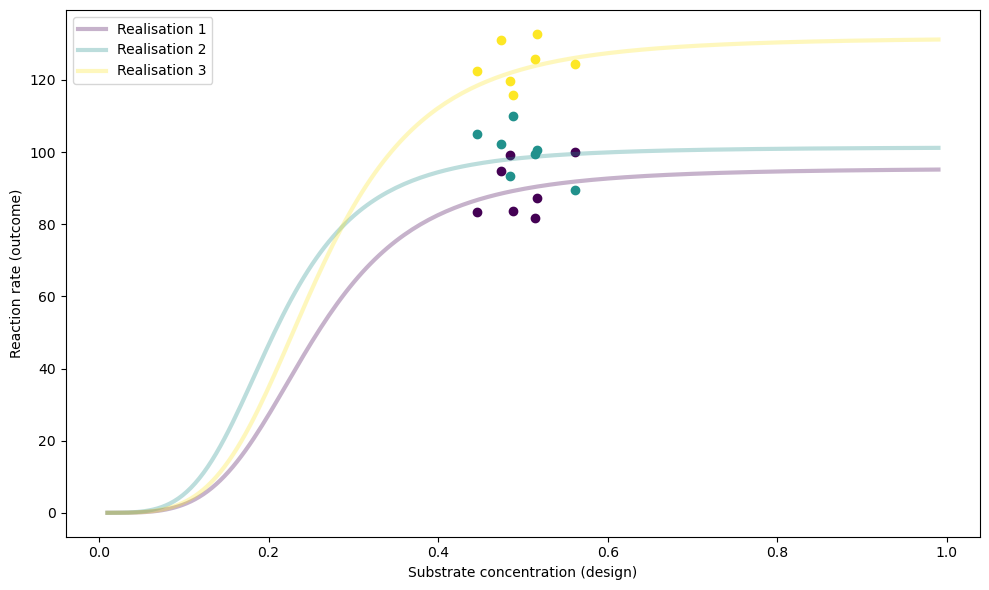

In [3]:
torch.manual_seed(20240929)
num_parameters = 2 # \theta = \theta_1, \theta_2 as described above
num_designs = 7
num_test_sims = 3
train_batch_size = 128
num_grad_steps = 5000

xi = torch.randn(1, num_designs) * 0.1

simulator = MichaelisMenten(designs=xi.clone(), learn_designs=False)

test_sims = simulator.sample(batch_shape=(num_test_sims,))  # type: ignore
simulator.plot_realisations(test_sims["theta"])

Let's now set up and learn the NPE $q(\theta \mid y, \xi)$, keeping the designs fixed. We'll use a normalising flow to model this posterior distribution. For an extended tutorial on NPE, checkout [this notebook](https://github.com/stefanradev93/BayesFlow/blob/dev/examples/TwoMoons_FlowMatching.ipynb).

Setting up and training amortised posteriors in BayesFlow is straightforward:

1.  We'll create a `CouplingFlow` network to parameterise our posterior.
2.  We'll `build` the network by specifying input shapes.
3.  We'll train the network using simulated data from our `MichaelisMenten` model defined above.


In [4]:
print("***** Designs before training *****\n", torch.sigmoid(simulator.designs), "\n")
with torch.enable_grad():
    posterior_net = bf.networks.CouplingFlow()
    # compile/build the torch model posterior_net
    posterior_net.build(
        xz_shape=(32, num_parameters), conditions_shape=(32, num_designs * 2)
    )

    # train the designs:
    optim = torch.optim.AdamW(posterior_net.parameters(), lr=1e-3)
    pbar = trange(num_grad_steps, desc="Training: loss =")

    for i in pbar:
        optim.zero_grad()
        theta, y, scaled_y = simulator(batch_shape=(train_batch_size,))
        log_prob = -posterior_net.log_prob(
            theta,
            conditions=torch.cat(
                [scaled_y, simulator.designs.detach().expand(scaled_y.shape)], dim=-1
            ),
        )
        loss = log_prob.mean(-1)
        loss.backward()
        optim.step()
        if i % 50 == 0:
            pbar.set_description(f"Training: loss = {loss}")

print("\n***** Designs after training (unchanged) *****\n", torch.sigmoid(simulator.designs)) # unchanged

***** Designs before training *****
 tensor([[0.4745, 0.4456, 0.5147, 0.5618, 0.4844, 0.4880, 0.5162]]) 



Training: loss = -3.9650492668151855: 100%|██████████| 5000/5000 [02:41<00:00, 30.92it/s]


***** Designs after training (unchanged) *****
 tensor([[0.4745, 0.4456, 0.5147, 0.5618, 0.4844, 0.4880, 0.5162]])


Now, let's evaluate how well our approximate posterior matches the ground truth. We'll do this by:

1.  Running Hamiltonian Monte Carlo (HMC) to obtain a high-quality posterior estimate.
2.  Visually comparing our approximate posterior to the HMC results for our test simulations.

This comparison will give us a quick, qualitative assessment of our learnt posterior.

**Note:** While this visual inspection is useful, more rigorous and quantitative evaluation methods exist. We'll explore these advanced techniques in a future blog post.


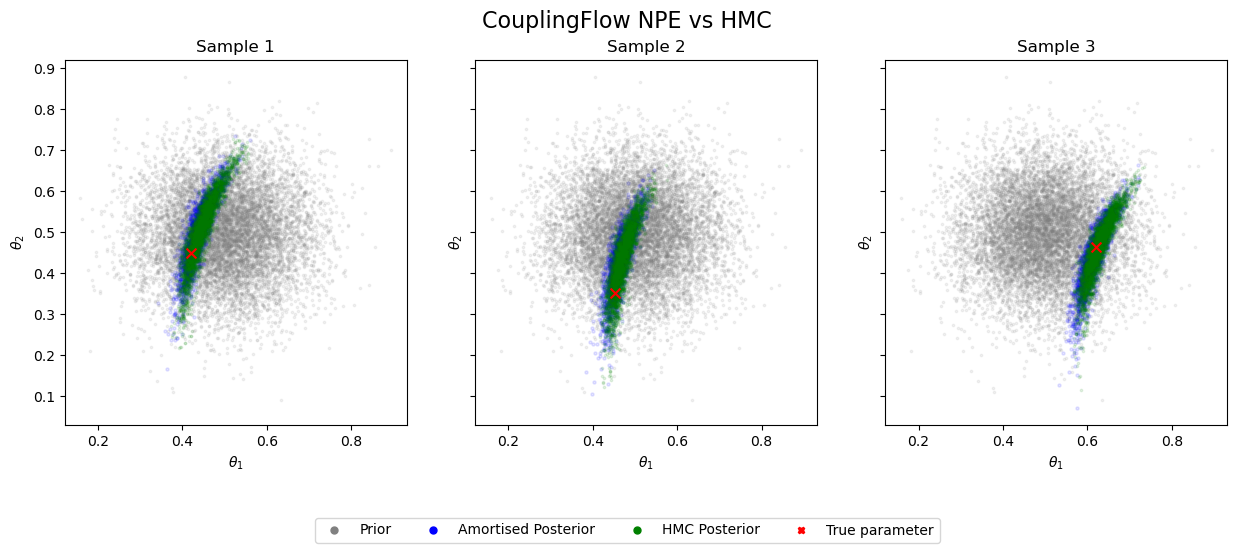

In [5]:
# sample from the amortised posterior
amortised_posterior_samples = torch.stack(
    [
        posterior_net.sample((2000,), conditions=torch.cat(
                [yy.unsqueeze(0).expand(2000, -1), simulator.designs.expand(2000, -1)], dim=-1
            ),
        )
        for yy in test_sims["scaled_y"]
    ],
    dim=0,
)
# sample from the hmc posterior: we pass the actual (unscaled) y
hmc_posterior_samples = simulator.run_hmc_posterior(test_sims["y"])

plot_posterior_comparison(
    amortised_posterior_samples,
    hmc_posterior_samples,
    true_theta=test_sims["theta"],
    prior_samples=simulator.prior().sample((10000,)),
)

The samples from our learnt posterior show excellent agreement with the ground truth.
However, these posteriors exhibit considerable uncertainty (wide distributions).

Can we reduce this uncertainty (i.e., decrease the entropy) in our parameter estimates by optimising our choice of experimental designs?


### Learning the designs along with the normalising flow posterior

We will use the same initial designs and the same architecture (`CouplingFlow`) for the NPE as before. The two changes we are making are:

1. Setting `learn_designs=True` when instantiating the `simulator`.
2. Passing the design parameters (`simulator.parameters()`) to the AdamW optimiser (`optim`).

This approach allows us to simultaneously maximise the EIG (by optimising the experimental designs) and tighten the BA bound (by improving the approximate posterior).


In [6]:
simulator = MichaelisMenten(designs=xi.clone(), learn_designs=True)
print("***** Designs before training *****\n", torch.sigmoid(simulator.designs), "\n")
with torch.enable_grad():
    posterior_net_designs = bf.networks.CouplingFlow()

    # could try to attach the x-s too. so secnd would be (32, 7*2)
    posterior_net_designs.build((32, num_parameters), (32, num_designs*2))

    # train the designs:
    optim = torch.optim.AdamW(
        list(simulator.parameters()) + list(posterior_net_designs.parameters()),
        lr=1e-3,
    )
    pbar = trange(num_grad_steps, desc="Training: loss =")

    for i in pbar:
        optim.zero_grad()
        theta, y, scaled_y = simulator(batch_shape=(train_batch_size,))
        log_prob = -posterior_net_designs.log_prob(
            theta, 
            conditions=torch.cat(
                [scaled_y, simulator.designs.detach().expand(scaled_y.shape)], dim=-1
            ),
        )
        loss = log_prob.mean(-1)
        loss.backward()
        optim.step()
        if i % 50 == 0:
            pbar.set_description(f"Training: loss = {loss}")

print("\n***** Designs after training *****\n", torch.sigmoid(simulator.designs))

***** Designs before training *****
 tensor([[0.4745, 0.4456, 0.5147, 0.5618, 0.4844, 0.4880, 0.5162]]) 



Training: loss = -5.109278678894043: 100%|██████████| 5000/5000 [02:42<00:00, 30.70it/s] 


***** Designs after training *****
 tensor([[0.2885, 0.2667, 0.7111, 0.7969, 0.3647, 0.6234, 0.7139]])


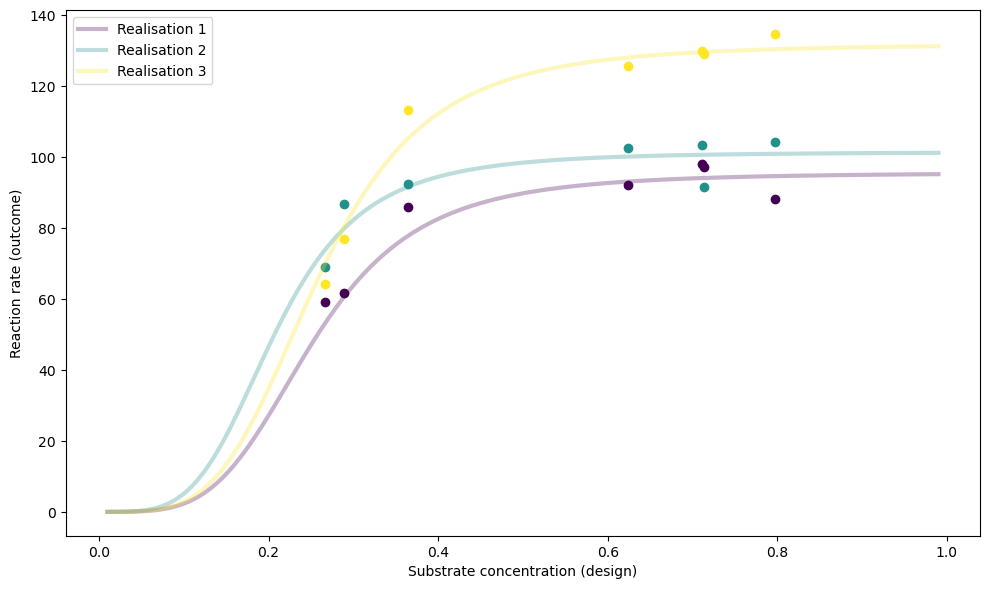

In [7]:
# plot the final designs
simulator.plot_realisations(theta=test_sims["theta"])

Let's look at the resulting posteriors for the same set of test parameters:


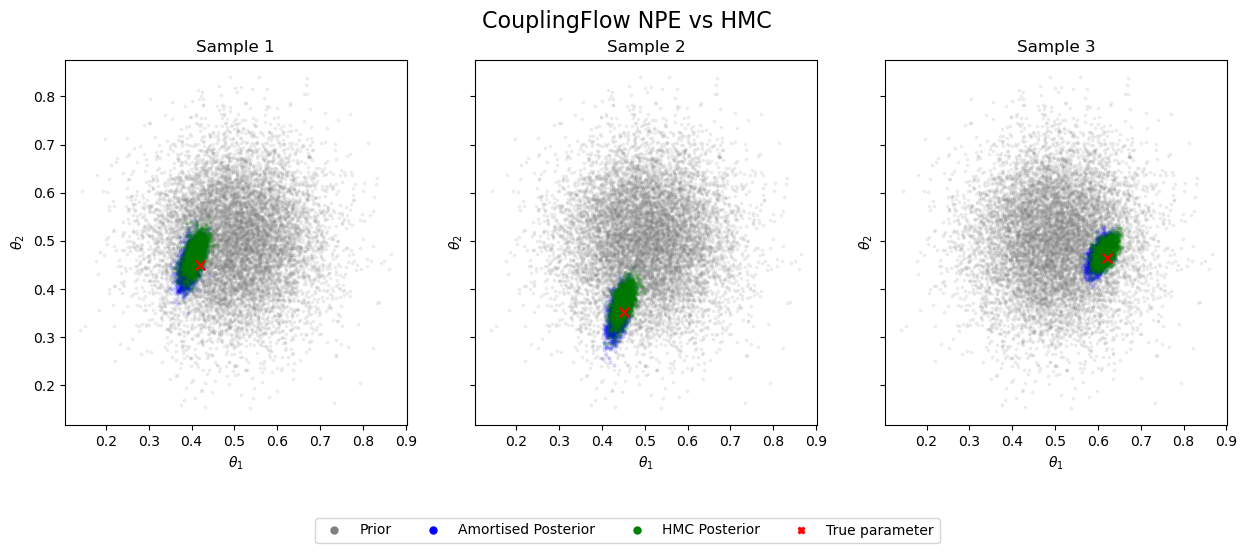

In [8]:
# Obtain the outcomes under the learnt design
designed_y, designed_scaled_y = simulator.run_policy(test_sims["theta"])

designed_amortised_samples = torch.stack(
    [
        posterior_net_designs.sample(
            (2000,), 
            conditions=torch.cat(
                [yy.unsqueeze(0).expand(2000, -1), simulator.designs.expand(2000, -1)], dim=-1
            ),
        )
        for yy in designed_scaled_y
    ],
    dim=0,
)

designed_hmc_samples = simulator.run_hmc_posterior(designed_y)

plot_posterior_comparison(
    amortised_posterior_samples=designed_amortised_samples,
    hmc_posterior_samples=designed_hmc_samples,
    true_theta=test_sims["theta"],
    prior_samples=simulator.prior().sample((10000,)),
)

As before, the amortised posteriors closely align with the ground truth.
The key improvement is that by learning optimal designs, we've achieved significantly more concentrated posteriors using the same amount of data! #gains 🚀 🎉


#### References

[1] Rainforth, T., Foster, A., Ivanova, D. R., & Bickford Smith, F. (2024). Modern Bayesian experimental design. Statistical Science, 39(1), 100-114.

[2] Huan, X., Jagalur, J., & Marzouk, Y. (2024). Optimal experimental design: Formulations and computations. Acta Numerica, 33, 715-840.

[3] Barber, D., & Agakov, F. (2004). The im algorithm: a variational approach to information maximization. Advances in neural information processing systems, 16(320), 201.

[4] Foster, A., Jankowiak, M., O’Meara, M., Teh, Y. W., & Rainforth, T. (2020, June). A unified stochastic gradient approach to designing bayesian-optimal experiments. In International Conference on Artificial Intelligence and Statistics (pp. 2959-2969). PMLR.
